Import libraries

In [27]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score

Import dataset

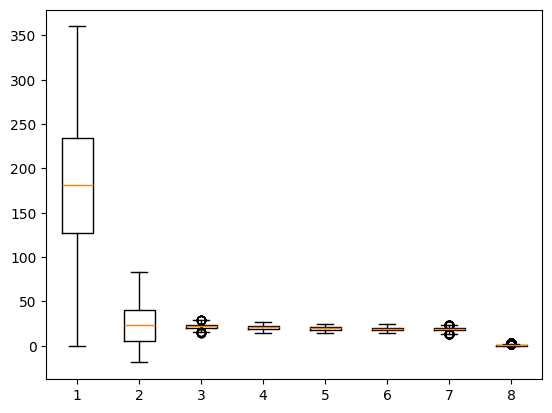

              alpha         delta             u             g             r  \
count  97814.000000  97814.000000  97814.000000  97814.000000  97814.000000   
mean     177.599567     24.150785     22.071659     20.630475     19.636028   
std       96.535545     19.654619      2.239830      2.023809      1.834898   
min        0.005528    -18.785328     14.311050     14.520380     14.168760   
25%      127.478240      5.144758     20.332845     18.938333     18.100860   
50%      180.868223     23.685853     22.157445     21.092910     20.105900   
75%      233.890810     39.908920     23.670853     22.131880     21.031697   
max      359.999810     83.000519     29.234380     26.714980     25.121300   

                  i             z      redshift  
count  97814.000000  97814.000000  97814.000000  
mean      19.065337     18.747675      0.521963  
std        1.728697      1.737013      0.595197  
min       13.899870     13.559570     -0.009971  
25%       17.699045     17.430633     

In [28]:
df = pd.read_csv('preprocessed_data.csv',index_col=0)
X = df.drop(columns=['class'])
Y = df['class']
plt.boxplot(X)
plt.show()
print(df.describe())

Discretization

In [29]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

dc.fit(X[['alpha']])
X['alpha']= dc.transform(X[['alpha']])

dc.fit(X[['delta']])
X['delta']= dc.transform(X[['delta']])

dc.fit(X[['u']])
X['u']= dc.transform(X[['u']])

dc.fit(X[['g']])
X['g']= dc.transform(X[['g']])

dc.fit(X[['r']])
X['r']= dc.transform(X[['r']])

dc.fit(X[['i']])
X['i']= dc.transform(X[['i']])

dc.fit(X[['z']])
X['z']= dc.transform(X[['z']])

dc.fit(X[['redshift']])
X['redshift']= dc.transform(X[['redshift']])

print(X.head())

   alpha  delta    u    g    r    i    z  redshift
0    3.0    5.0  7.0  7.0  5.0  5.0  5.0       3.0
1    3.0    5.0  8.0  7.0  9.0  8.0  8.0       4.0
2    3.0    5.0  8.0  7.0  6.0  5.0  5.0       3.0
3    8.0    1.0  5.0  8.0  7.0  7.0  5.0       4.0
4    9.0    3.0  2.0  1.0  1.0  1.0  1.0       0.0


Set Up Evaluation Parameters

In [30]:
criterion = ['gini', 'entropy','log_loss']
max_depth = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
score = {
    'gini' : [],
    'entropy' : [],
    'log_loss' : []
}
for criteria in criterion:  
    for depth in max_depth:
        clf = tree.DecisionTreeClassifier(criterion=criteria, max_depth=depth)
        score[criteria].append(np.mean(cross_val_score(clf, X, Y, cv=10)))
    
print(score)

{'gini': [np.float64(0.814770914012582), np.float64(0.8803749486479312), np.float64(0.9026417659396685), np.float64(0.9109432108044523), np.float64(0.9155438095518601), np.float64(0.9177110774625096), np.float64(0.9149303398067232), np.float64(0.9133149944111348), np.float64(0.9104319853200549), np.float64(0.9086224662367137), np.float64(0.9066391073484992), np.float64(0.9061790661823939), np.float64(0.9059541674802485), np.float64(0.9061074988579895), np.float64(0.9060768281927054)], 'entropy': [np.float64(0.8615638650836891), np.float64(0.8858036354996756), np.float64(0.90619950458279), np.float64(0.9119757759333409), np.float64(0.91790539224891), np.float64(0.9186618889898132), np.float64(0.9165660786601757), np.float64(0.9135910607087696), np.float64(0.910084402911599), np.float64(0.9088269234029374), np.float64(0.9071196193154307), np.float64(0.9068435854182262), np.float64(0.907027626132732), np.float64(0.9066391167550757), np.float64(0.9067311381575038)], 'log_loss': [np.float64

Plotting results (Gini)

Text(0.5, 1.0, 'Score vs. Max Depth (Gini Index)')

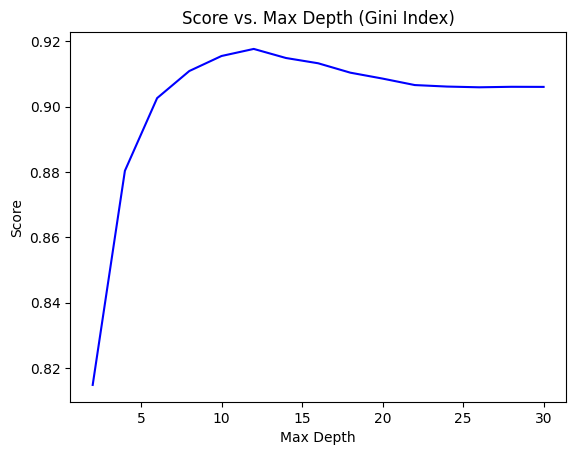

In [31]:
gini = score['gini']
entropy = score['entropy']
log_loss = score['log_loss']

plt.plot(max_depth, gini, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Gini Index)')

Entropy

Text(0.5, 1.0, 'Score vs. Max Depth (Entropy)')

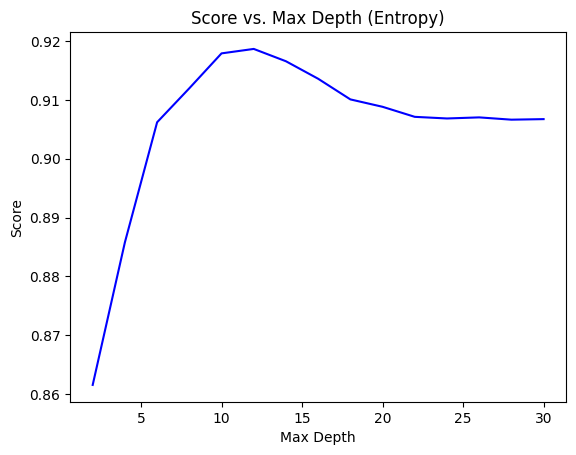

In [32]:
plt.plot(max_depth, entropy, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Entropy)')

Log Loss

Text(0.5, 1.0, 'Score vs. Max Depth (Log Loss)')

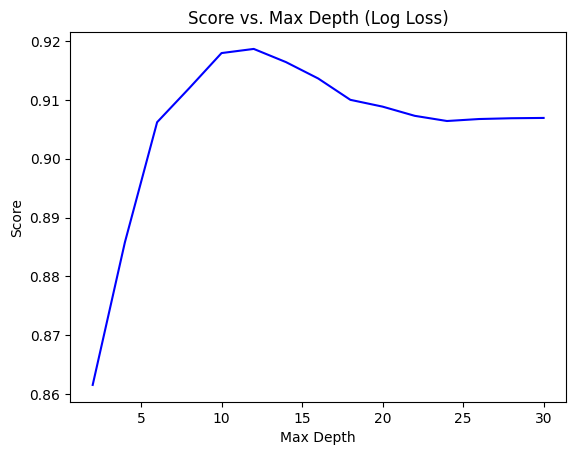

In [33]:
plt.plot(max_depth, log_loss, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Log Loss)')

Final Processing

In [35]:
print("Best Max Depth (Gini): ", (np.argmax(gini)+1)*2)
print("Score: ", max(gini))
print("Best Max Depth (Entropy): ", (np.argmax(entropy)+1)*2)
print("Score: ", max(entropy))
print("Best Max Depth (Log Loss): ", (np.argmax(log_loss)+1)*2)
print("Score: ", max(log_loss))


Best Max Depth (Gini):  12
Score:  0.9177110774625096
Best Max Depth (Entropy):  12
Score:  0.9186618889898132
Best Max Depth (Log Loss):  12
Score:  0.9186516609056264
